In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# import data from "C:\Data\hershey_promo_impact\Circana_V_IRI_MKT_LVL_SRGMSALTY_ALL_DATA_BM_2019_2024_10_digits.csv", note we are in wsl, change the path to the correct one


import pandas as pd

df = pd.read_csv("/mnt/c/Data/hershey_promo_impact/Circana_V_IRI_MKT_LVL_SRGMSALTY_ALL_DATA_BM_2019_2024_10_digits.csv",
                 usecols=['UPC_10_DIGIT',
                        'GEOGRAPHY_KEY',  
                         'WKENDING_DATE',
                         'UNIT_SALES',
                         'VOLUME_SALES',
                         'DOLLAR_SALES',
                         'PRICE_PER_UNIT'
                         # Add other columns you need
                         ])

# check the data
df.head()



,UPC_10_DIGIT,GEOGRAPHY_KEY,UNIT_SALES,VOLUME_SALES,DOLLAR_SALES,PRICE_PER_UNIT,WKENDING_DATE
0,1566577126,27477690,2757.0,1034.0,12969.83,4.70,2019-10-27
1,5025100480,27400649,209.0,78.0,1277.17,6.10,2019-10-27
2,5025100403,27400649,485.0,303.0,2312.56,4.77,2019-10-27
3,1307459792,27477690,2871.0,897.0,5960.13,2.08,2019-10-27
4,1202089924,27477690,8577.0,2359.0,13800.61,1.61,2019-10-27


In [11]:
# Create panel structure
df['item_id'] = df['UPC_10_DIGIT'].astype(str) + '_' + df['GEOGRAPHY_KEY'].astype(str)
df['WKENDING_DATE'] = pd.to_datetime(df['WKENDING_DATE'])
df = df.set_index(['item_id', 'WKENDING_DATE']).sort_index()

# Verify the structure
print("Index levels:", df.index.names)
print("\nNumber of unique items:", len(df.index.get_level_values('item_id').unique()))
print("\nDate range:", 
      df.index.get_level_values('WKENDING_DATE').min(),
      "to",
      df.index.get_level_values('WKENDING_DATE').max())

Index levels: ['item_id', 'WKENDING_DATE']

Number of unique items: 15685

Date range: 2019-10-27 00:00:00 to 2024-12-29 00:00:00


In [31]:
# Print summary statistics
print("\nSummary of log_price:")
print(df['log_price'].describe())
print("\nSummary of log_quantity:")
print(df['log_quantity'].describe())

# Check for infinite values
print("\nInfinite values:")
print("log_price:", np.isinf(df['log_price']).sum())
print("log_quantity:", np.isinf(df['log_quantity']).sum())

# Check for NaN values
print("\nNaN values:")
print("log_price:", df['log_price'].isna().sum())
print("log_quantity:", df['log_quantity'].isna().sum())


Summary of log_price:
count    1.589282e+06
mean     1.320528e+00
std      5.784930e-01
min     -2.995732e+00
25%      9.162907e-01
50%      1.358409e+00
75%      1.771557e+00
max      4.602968e+00
Name: log_price, dtype: float64

Summary of log_quantity:
count    1.589282e+06
mean             -inf
std               NaN
min              -inf
25%      4.158883e+00
50%      5.739793e+00
75%      7.119636e+00
max      1.345798e+01
Name: log_quantity, dtype: float64

Infinite values:
log_price: 0
log_quantity: 29

NaN values:
log_price: 0
log_quantity: 0


/mnt/c/Users/AdlerXie/Documents/GitHub/Hershey_promo/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Graphs

/tmp/ipykernel_3497/4256454814.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['log_quantity'] = np.log(df_graph['UNIT_SALES'])
/tmp/ipykernel_3497/4256454814.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['log_price'] = np.log(df_graph['PRICE_PER_UNIT'])


Original number of items: 15685
Number of items after filtering: 14871
Sales volume cutoff: 9.00 units

Log price range: -2.41 to 4.60
Bin width: 0.467


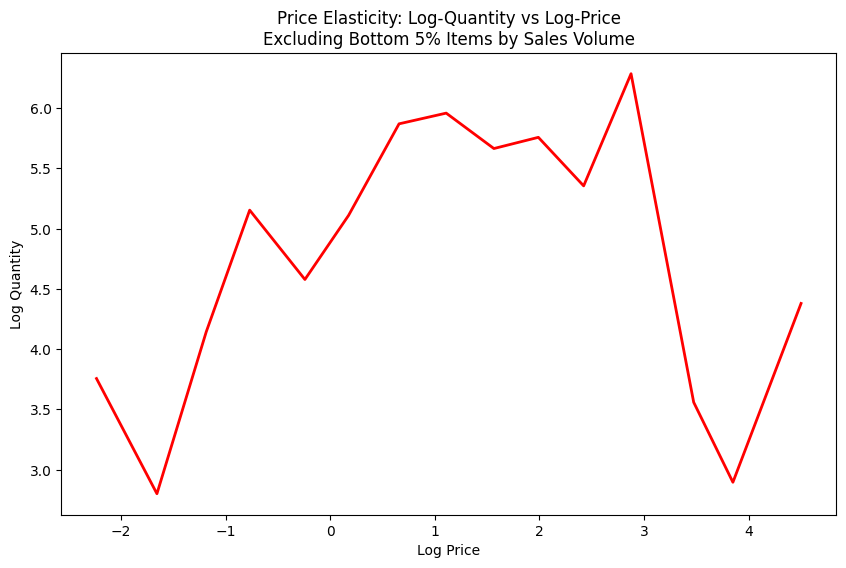

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Calculate total units sold for each item
item_total_sales = df.groupby('item_id')['UNIT_SALES'].sum()

# Find the 5th percentile cutoff
sales_cutoff = np.percentile(item_total_sales, 5)

# Get list of items to keep (above 5th percentile)
items_to_keep = item_total_sales[item_total_sales > sales_cutoff].index

# Filter dataframe to keep only these items
df_filtered = df[df.index.get_level_values('item_id').isin(items_to_keep)]

# Create graph dataframe with positive values only
df_graph = df_filtered[(df_filtered['UNIT_SALES'] > 1) & (df_filtered['PRICE_PER_UNIT'] > 0)]
df_graph['log_quantity'] = np.log(df_graph['UNIT_SALES'])
df_graph['log_price'] = np.log(df_graph['PRICE_PER_UNIT'])

# Create the plot
plt.figure(figsize=(10, 6))

# Create fixed bins for log_price
min_price = df_graph['log_price'].min()
max_price = df_graph['log_price'].max()
n_bins = 15
bins = np.linspace(min_price, max_price, n_bins+1)  # equal-width bins in log price
bin_means_x = []
bin_means_y = []

# For each bin
for i in range(len(bins)-1):
    # Get data in this bin
    mask = (df_graph['log_price'] >= bins[i]) & (df_graph['log_price'] < bins[i+1])
    bin_data_x = df_graph.loc[mask, 'log_price']
    bin_data_y = df_graph.loc[mask, 'log_quantity']
    
    if len(bin_data_x) > 0:  # if bin has data
        bin_means_x.append(bin_data_x.mean())
        bin_means_y.append(bin_data_y.mean())

# Plot the bin means
plt.plot(bin_means_x, bin_means_y, 'r-', linewidth=2)

plt.title('Price Elasticity: Log-Quantity vs Log-Price\nExcluding Bottom 5% Items by Sales Volume')
plt.xlabel('Log Price')
plt.ylabel('Log Quantity')

# Print some statistics
print(f"Original number of items: {len(item_total_sales)}")
print(f"Number of items after filtering: {len(items_to_keep)}")
print(f"Sales volume cutoff: {sales_cutoff:.2f} units")
print(f"\nLog price range: {min_price:.2f} to {max_price:.2f}")
print(f"Bin width: {(max_price - min_price)/n_bins:.3f}")

plt.show()

/tmp/ipykernel_3497/1860248959.py:16: MemoryWarning: Using low-memory algorithm to estimate two-way model. Explicitly set low_memory=True to silence this message.  Set low_memory=False to use the standard algorithm that creates dummy variables for the smaller of the number of entities or number of time periods.
  results = model.fit(cov_type='clustered', cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:           log_quantity   R-squared:                        0.0020
Estimator:                   PanelOLS   R-squared (Between):              0.1289
No. Observations:             1537646   R-squared (Within):              -0.0037
Date:                Mon, Jan 27 2025   R-squared (Overall):              0.1209
Time:                        15:07:25   Log-likelihood                -2.246e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2980.1
Entities:                       14862   P-value                           0.0000
Avg Obs:                       103.46   Distribution:               F(1,1522513)
Min Obs:                       1.0000                                           
Max Obs:                       301.00   F-statistic (robust):             70.609
                            

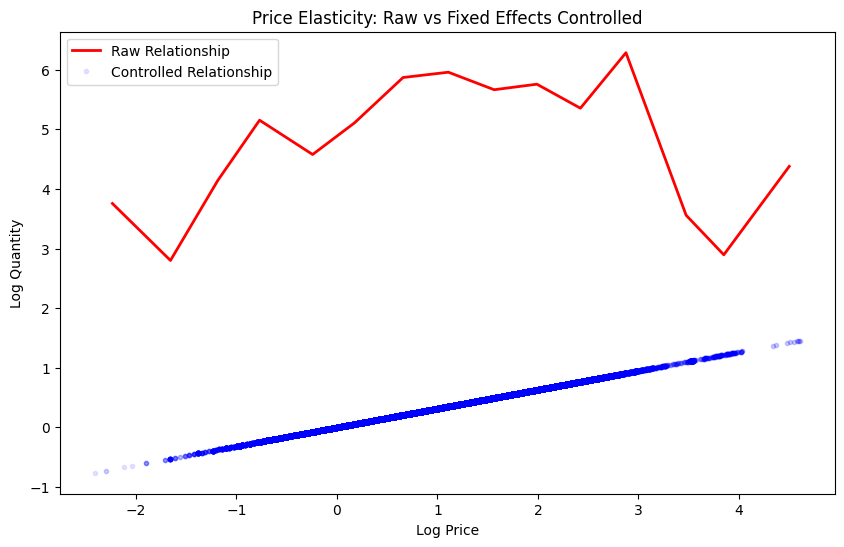

In [40]:
from linearmodels.panel import PanelOLS

# Prepare data for panel regression
df_panel = df_graph.copy()

# Create log transformations if not already done
df_panel['log_quantity'] = np.log(df_panel['UNIT_SALES'])
df_panel['log_price'] = np.log(df_panel['PRICE_PER_UNIT'])

# Run panel regression with two-way fixed effects
model = PanelOLS(df_panel['log_quantity'], 
                 df_panel['log_price'],
                 entity_effects=True,  # item fixed effects
                 time_effects=True)    # time fixed effects

results = model.fit(cov_type='clustered', cluster_entity=True)

# Print results
print(results)

# Plot original binned relationship and controlled relationship
plt.figure(figsize=(10, 6))
plt.plot(bin_means_x, bin_means_y, 'r-', linewidth=2, label='Raw Relationship')
plt.plot(df_panel['log_price'], 
         results.fitted_values, 
         'b.', alpha=0.1, 
         label='Controlled Relationship')

plt.title('Price Elasticity: Raw vs Fixed Effects Controlled')
plt.xlabel('Log Price')
plt.ylabel('Log Quantity')
plt.legend()
plt.show()